<a href="https://colab.research.google.com/github/kdambrowski/Space_ship_titanic/blob/main/Spaceship_titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Necessary packages (PIP instalation)

In [108]:
!pip install ydata-profiling -q
print('instalation has been complited')

instalation has been complited


In [109]:
!pip install xgboost -q
print('instalation has been complited')

instalation has been complited


In [110]:
!pip install lightgbm -q
print('instalation has been complited')

instalation has been complited


In [111]:
!pip install catboost -q
print('instalation has been complited')

instalation has been complited


In [112]:
!pip install ipywidgets -q
print('instalation has been complited')

instalation has been complited


In [113]:
!pip3 install optuna -q
print('instalation has been complited')

instalation has been complited


# Library

In [114]:
import os
import shutil
import warnings
import optuna
import torch

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

from tqdm import tqdm
from google.colab import output
from catboost import CatBoostClassifier as cbs
from lightgbm import LGBMClassifier as lgb
from xgboost import XGBClassifier
from ydata_profiling import ProfileReport
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from scipy.stats import normaltest
from sklearn.model_selection import train_test_split, KFold
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Classes and functions

In [115]:
class LogisticRegression_pt(torch.nn.Module):
     def __init__(self, input_dim, output_dim):
         super(LogisticRegression_pt, self).__init__()
         self.linear = torch.nn.Linear(input_dim, output_dim)
     def forward(self, x):
         outputs = torch.sigmoid(self.linear(x))
         return outputs

def calculate_metrics(target, prediction, average='macro'):
    accuracy = accuracy_score(target, prediction)
    precision = precision_score(target, prediction, average=average, zero_division=0)
    recall = recall_score(target, prediction, average=average, zero_division=0)
    f1 = f1_score(target, prediction, average=average, zero_division=0)
    mislabeled = (target != prediction).sum()
    total = len(target)
    return accuracy, precision, recall, f1, mislabeled, total

def print_results(metrics, classifier_id='classifier'):
    print(f'Results for {classifier_id}')
    print('----')
    print(f'  Accuracy: {metrics[0]*100:.4f}%')
    print(f'  Precision: {metrics[1]*100:.4f}%')
    print(f'  Recall:    {metrics[2]*100:.4f}%')
    print(f'  F1 score:  {metrics[3]*100:.4f}%')
    print(f'  Mislabeled {metrics[4]} out of {metrics[5]}')
    print('\n')

def plot_confusion_matrix(confusion_matrix, classes, title=None,
                          title_appendix='',
                          cmap=plt.cm.Blues):
    # tytuł wykresu
    if title_appendix:
        title_appendix = f'({title_appendix})'
    # czeny ty nie ma else
    if title is None:
        title = f'Confusion matrix {title_appendix}'
    
    fig, ax = plt.subplots(figsize=(10,5))
    # rysuje CM
    img = ax.imshow(confusion_matrix, cmap=cmap)
    # dodaje pasek z boku .figure.colorbar(zmienna z wykresem, dane do wykresu)
    ax.figure.colorbar(img, ax=ax)
    # dodatki do wykresu
    ax.set_xticks(np.arange(confusion_matrix.shape[1]))
    ax.set_xticklabels(classes, rotation=45, ha='right', rotation_mode='anchor')
    ax.set_yticks(np.arange(confusion_matrix.shape[0]))
    ax.set_yticklabels(classes, rotation=45, ha='right', rotation_mode='anchor')
    ax.set_title(title)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    
    # etykiety
    fmt = '.2f' if confusion_matrix.dtype == 'float' else 'd'
    thresh = confusion_matrix.max() / 2
    for y, row in enumerate(confusion_matrix):
        for x, cell in enumerate(row):
            ax.text(x, y, format(cell, fmt),
                    ha='center', va='center',
                    color='white' if cell > thresh else 'black')
    fig.tight_layout()
    
    return ax

def normalize_confusion_matrix(confusion_matrix):
    return confusion_matrix.astype(
        'float') / confusion_matrix.sum(
        axis=1)[np.newaxis].T

# Settings and variables 

In [116]:
url_sample ='https://raw.githubusercontent.com/kdambrowski/Space_ship_titanic/main/sample_submission_space_titanic.csv'
url_test ='https://raw.githubusercontent.com/kdambrowski/Space_ship_titanic/main/test_space_titanic.csv'
url_train ='https://raw.githubusercontent.com/kdambrowski/Space_ship_titanic/main/train_space_titanic.csv'

In [117]:
space_titanic_test = pd.read_csv(url_test)
space_titanic_train = pd.read_csv(url_train)
space_titanic_sample = pd.read_csv(url_sample)

#Data exploration

## Train DS exploration

In [118]:
space_titanic_train.head(10)

PassengerId HomePlanet CryoSleep  Cabin    Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P    TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S    TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S    TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S    TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S    TRAPPIST-1e  16.0  False   
5     0005_01      Earth     False  F/0/P  PSO J318.5-22  44.0  False   
6     0006_01      Earth     False  F/2/S    TRAPPIST-1e  26.0  False   
7     0006_02      Earth      True  G/0/S    TRAPPIST-1e  28.0  False   
8     0007_01      Earth     False  F/3/S    TRAPPIST-1e  35.0  False   
9     0008_01     Europa      True  B/1/P    55 Cancri e  14.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck                Name  \
0          0.0        0.0           0.0     0.0     0.0     Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0        Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0       Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0        Solam Susent   
4        303.0       70.0         151.0   565.0     2.0   Willy Santantines   
5          0.0      483.0           0.0   291.0     0.0   Sandie Hinetthews   
6         42.0     1539.0           3.0     0.0     0.0  Billex Jacostaffey   
7          0.0        0.0           0.0     0.0     NaN  Candra Jacostaffey   
8          0.0      785.0          17.0   216.0     0.0       Andona Beston   
9          0.0        0.0           0.0     0.0     0.0      Erraiam Flatic   

   Transported  
0        False  
1         True  
2        False  
3        False  
4         True  
5         True  
6         True  
7         True  
8         True  
9         True

In [119]:
space_titanic_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [120]:
space_titanic_train.isnull().sum().sort_values()

PassengerId       0
Transported       0
Age             179
RoomService     181
Destination     182
FoodCourt       183
Spa             183
VRDeck          188
Cabin           199
Name            200
HomePlanet      201
VIP             203
ShoppingMall    208
CryoSleep       217
dtype: int64

In [121]:
is_null_filter = space_titanic_train.isnull().sum(axis=1).astype(bool)
space_titanic_train_wo_null = space_titanic_train[~is_null_filter]

In [122]:
non_num_col = space_titanic_train_wo_null.select_dtypes(['object'])
value_col = space_titanic_train_wo_null.select_dtypes(['float64'])

In [123]:
space_titanic_train_wo_null['Age'].value_counts(sort=True)

24.0    255
18.0    255
22.0    234
21.0    227
19.0    225
       ... 
72.0      3
79.0      2
75.0      2
76.0      2
77.0      1
Name: Age, Length: 80, dtype: int64

In [124]:
np.array(non_num_col['HomePlanet'].value_counts().index)[:10]

array(['Earth', 'Europa', 'Mars'], dtype=object)

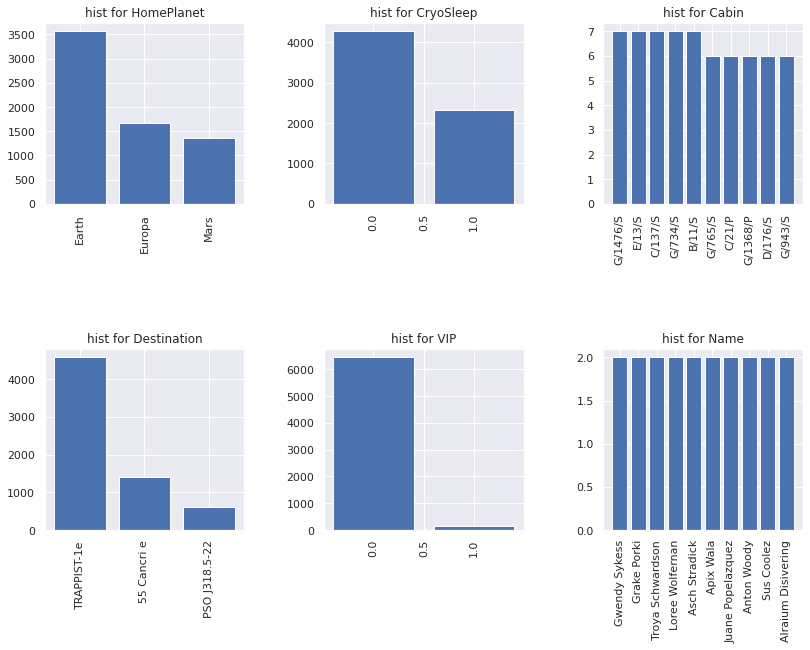

In [125]:
i = 0
for col in non_num_col.columns:
  if (non_num_col[[col]].value_counts()>1).sum()>0:
    ax = plt.subplot(3,3,i+1)
    plt.bar(np.array(non_num_col[col].value_counts(sort=True).index)[:10], 
    np.array(non_num_col[col].value_counts())[:10])
    plt.title(f'hist for {col}')
    plt.subplots_adjust(left=0.1,
                      bottom=0.1,
                      right=1,
                      top=1.5,
                      wspace=0.4,
                      hspace=0.8)
    plt.xticks(rotation=90)
    i = i+1
    


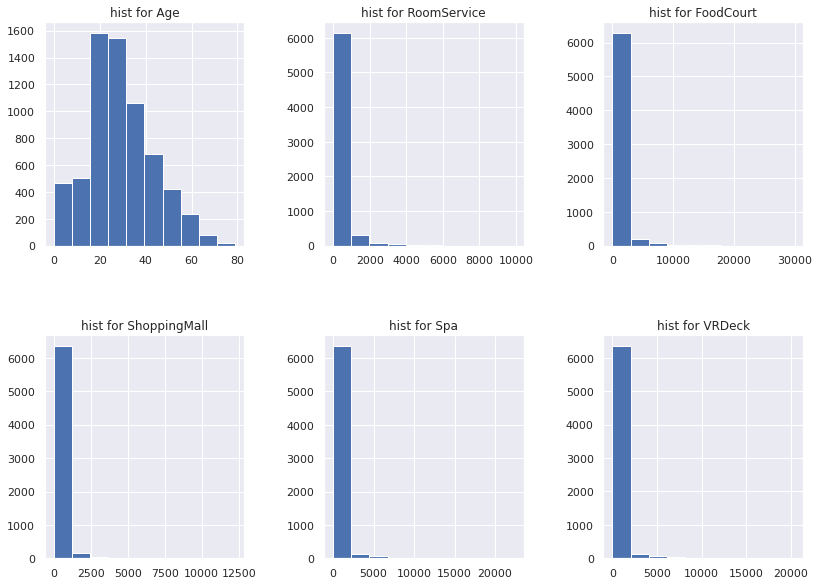

In [126]:
i=0
for col in value_col.columns:
  ax = plt.subplot(2,3,i+1)
  plt.hist(value_col[col])
  plt.title(f'hist for {col}')
  plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=1,
                    top=1,
                    wspace=0.4,
                    hspace=0.4)
  i = i+1

In [127]:
space_titanic_train_wo_null['Age'][space_titanic_train_wo_null['Age'].between(0,1)].value_counts()

0.0    140
1.0     54
Name: Age, dtype: int64

In [128]:
space_titanic_train_wo_null_age_clearing = space_titanic_train_wo_null['Age']>0
space_titanic_train_wo_null_age_clearing =space_titanic_train_wo_null[space_titanic_train_wo_null_age_clearing]

##Pd profiling_train

In [129]:
pd_profile_train = ProfileReport(space_titanic_train, title="Profiling Report")

In [130]:
pd_profile_train.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [131]:
X_train = pd.DataFrame(space_titanic_train_wo_null_age_clearing)
y_train = X_train.loc[:,'Transported'].astype(float)
X_train = X_train.drop(columns ='Transported')

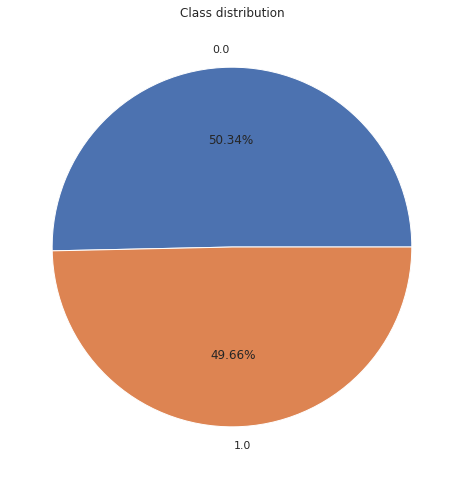

In [132]:
plt.pie(y_train.value_counts(normalize=True), labels=set(y_train), autopct='%1.2f%%')
plt.title('Class distribution')
plt.show()

##Test_exploration

In [133]:
space_titanic_test.head(2)

PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0013_01      Earth      True  G/3/S  TRAPPIST-1e  27.0  False   
1     0018_01      Earth     False  F/4/S  TRAPPIST-1e  19.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck             Name  
0          0.0        0.0           0.0     0.0     0.0  Nelly Carsoning  
1          0.0        9.0           0.0  2823.0     0.0   Lerome Peckers

In [134]:
space_titanic_test.describe()

Age   RoomService     FoodCourt  ShoppingMall           Spa  \
count  4186.000000   4195.000000   4171.000000   4179.000000   4176.000000   
mean     28.658146    219.266269    439.484296    177.295525    303.052443   
std      14.179072    607.011289   1527.663045    560.821123   1117.186015   
min       0.000000      0.000000      0.000000      0.000000      0.000000   
25%      19.000000      0.000000      0.000000      0.000000      0.000000   
50%      26.000000      0.000000      0.000000      0.000000      0.000000   
75%      37.000000     53.000000     78.000000     33.000000     50.000000   
max      79.000000  11567.000000  25273.000000   8292.000000  19844.000000   

             VRDeck  
count   4197.000000  
mean     310.710031  
std     1246.994742  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%       36.000000  
max    22272.000000

In [135]:
space_titanic_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


In [136]:
space_titanic_test.isnull().sum().sort_values()

PassengerId       0
VRDeck           80
RoomService      82
HomePlanet       87
Age              91
Destination      92
CryoSleep        93
VIP              93
Name             94
ShoppingMall     98
Cabin           100
Spa             101
FoodCourt       106
dtype: int64

In [137]:
space_titanic_test_wo_null = space_titanic_test[~space_titanic_test.isnull()]

##Sample_exploration

In [138]:
space_titanic_sample

PassengerId  Transported
0        0013_01        False
1        0018_01        False
2        0019_01        False
3        0021_01        False
4        0023_01        False
...          ...          ...
4272     9266_02        False
4273     9269_01        False
4274     9271_01        False
4275     9273_01        False
4276     9277_01        False

[4277 rows x 2 columns]

In [139]:
space_titanic_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   PassengerId  4277 non-null   object
 1   Transported  4277 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 37.7+ KB


In [140]:
space_titanic_sample['Transported'].value_counts()

False    4277
Name: Transported, dtype: int64

# Merge sample ds with test ds

In [141]:
merged_test_and_sample_DF = pd.merge(left=space_titanic_test_wo_null,
         right=space_titanic_sample)

In [142]:
merged_test_and_sample_DF

PassengerId HomePlanet CryoSleep     Cabin    Destination   Age    VIP  \
0        0013_01      Earth      True     G/3/S    TRAPPIST-1e  27.0  False   
1        0018_01      Earth     False     F/4/S    TRAPPIST-1e  19.0  False   
2        0019_01     Europa      True     C/0/S    55 Cancri e  31.0  False   
3        0021_01     Europa     False     C/1/S    TRAPPIST-1e  38.0  False   
4        0023_01      Earth     False     F/5/S    TRAPPIST-1e  20.0  False   
...          ...        ...       ...       ...            ...   ...    ...   
4272     9266_02      Earth      True  G/1496/S    TRAPPIST-1e  34.0  False   
4273     9269_01      Earth     False       NaN    TRAPPIST-1e  42.0  False   
4274     9271_01       Mars      True   D/296/P    55 Cancri e   NaN  False   
4275     9273_01     Europa     False   D/297/P            NaN   NaN  False   
4276     9277_01      Earth      True  G/1498/S  PSO J318.5-22  43.0  False   

      RoomService  FoodCourt  ShoppingMall     Spa  VRDeck              Name  \
0             0.0        0.0           0.0     0.0     0.0   Nelly Carsoning   
1             0.0        9.0           0.0  2823.0     0.0    Lerome Peckers   
2             0.0        0.0           0.0     0.0     0.0   Sabih Unhearfus   
3             0.0     6652.0           0.0   181.0   585.0  Meratz Caltilter   
4            10.0        0.0         635.0     0.0     0.0   Brence Harperez   
...           ...        ...           ...     ...     ...               ...   
4272          0.0        0.0           0.0     0.0     0.0       Jeron Peter   
4273          0.0      847.0          17.0    10.0   144.0     Matty Scheron   
4274          0.0        0.0           0.0     0.0     0.0       Jayrin Pore   
4275          0.0     2680.0           0.0     0.0   523.0    Kitakan Conale   
4276          0.0        0.0           0.0     0.0     0.0  Lilace Leonzaley   

      Transported  
0           False  
1           False  
2           False  
3           False  
4           False  
...           ...  
4272        False  
4273        False  
4274        False  
4275        False  
4276        False  

[4277 rows x 14 columns]

##test_sample plofiler

In [143]:
pd_profiler_test_merged = ProfileReport(merged_test_and_sample_DF, title = 'TEST profiler')
pd_profiler_test_merged.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Modeling in case where test file will be trully values.

In [144]:
merged_all_DS = pd.concat([merged_test_and_sample_DF,
                           space_titanic_train_wo_null_age_clearing],
                           join='inner')
merged_all_DS

PassengerId HomePlanet CryoSleep     Cabin    Destination   Age    VIP  \
0        0013_01      Earth      True     G/3/S    TRAPPIST-1e  27.0  False   
1        0018_01      Earth     False     F/4/S    TRAPPIST-1e  19.0  False   
2        0019_01     Europa      True     C/0/S    55 Cancri e  31.0  False   
3        0021_01     Europa     False     C/1/S    TRAPPIST-1e  38.0  False   
4        0023_01      Earth     False     F/5/S    TRAPPIST-1e  20.0  False   
...          ...        ...       ...       ...            ...   ...    ...   
8688     9276_01     Europa     False    A/98/P    55 Cancri e  41.0   True   
8689     9278_01      Earth      True  G/1499/S  PSO J318.5-22  18.0  False   
8690     9279_01      Earth     False  G/1500/S    TRAPPIST-1e  26.0  False   
8691     9280_01     Europa     False   E/608/S    55 Cancri e  32.0  False   
8692     9280_02     Europa     False   E/608/S    TRAPPIST-1e  44.0  False   

      RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0             0.0        0.0           0.0     0.0     0.0    Nelly Carsoning   
1             0.0        9.0           0.0  2823.0     0.0     Lerome Peckers   
2             0.0        0.0           0.0     0.0     0.0    Sabih Unhearfus   
3             0.0     6652.0           0.0   181.0   585.0   Meratz Caltilter   
4            10.0        0.0         635.0     0.0     0.0    Brence Harperez   
...           ...        ...           ...     ...     ...                ...   
8688          0.0     6819.0           0.0  1643.0    74.0  Gravior Noxnuther   
8689          0.0        0.0           0.0     0.0     0.0    Kurta Mondalley   
8690          0.0        0.0        1872.0     1.0     0.0       Fayey Connon   
8691          0.0     1049.0           0.0   353.0  3235.0   Celeon Hontichre   
8692        126.0     4688.0           0.0     0.0    12.0   Propsh Hontichre   

      Transported  
0           False  
1           False  
2           False  
3           False  
4           False  
...           ...  
8688        False  
8689        False  
8690         True  
8691        False  
8692         True  

[10743 rows x 14 columns]

In [145]:
merged_all_DS.reset_index(drop=True)

PassengerId HomePlanet CryoSleep     Cabin    Destination   Age    VIP  \
0         0013_01      Earth      True     G/3/S    TRAPPIST-1e  27.0  False   
1         0018_01      Earth     False     F/4/S    TRAPPIST-1e  19.0  False   
2         0019_01     Europa      True     C/0/S    55 Cancri e  31.0  False   
3         0021_01     Europa     False     C/1/S    TRAPPIST-1e  38.0  False   
4         0023_01      Earth     False     F/5/S    TRAPPIST-1e  20.0  False   
...           ...        ...       ...       ...            ...   ...    ...   
10738     9276_01     Europa     False    A/98/P    55 Cancri e  41.0   True   
10739     9278_01      Earth      True  G/1499/S  PSO J318.5-22  18.0  False   
10740     9279_01      Earth     False  G/1500/S    TRAPPIST-1e  26.0  False   
10741     9280_01     Europa     False   E/608/S    55 Cancri e  32.0  False   
10742     9280_02     Europa     False   E/608/S    TRAPPIST-1e  44.0  False   

       RoomService  FoodCourt  ShoppingMall     Spa  VRDeck  \
0              0.0        0.0           0.0     0.0     0.0   
1              0.0        9.0           0.0  2823.0     0.0   
2              0.0        0.0           0.0     0.0     0.0   
3              0.0     6652.0           0.0   181.0   585.0   
4             10.0        0.0         635.0     0.0     0.0   
...            ...        ...           ...     ...     ...   
10738          0.0     6819.0           0.0  1643.0    74.0   
10739          0.0        0.0           0.0     0.0     0.0   
10740          0.0        0.0        1872.0     1.0     0.0   
10741          0.0     1049.0           0.0   353.0  3235.0   
10742        126.0     4688.0           0.0     0.0    12.0   

                    Name  Transported  
0        Nelly Carsoning        False  
1         Lerome Peckers        False  
2        Sabih Unhearfus        False  
3       Meratz Caltilter        False  
4        Brence Harperez        False  
...                  ...          ...  
10738  Gravior Noxnuther        False  
10739    Kurta Mondalley        False  
10740       Fayey Connon         True  
10741   Celeon Hontichre        False  
10742   Propsh Hontichre         True  

[10743 rows x 14 columns]

In [146]:
merged_all_DS.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10743 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   10743 non-null  object 
 1   HomePlanet    10656 non-null  object 
 2   CryoSleep     10650 non-null  object 
 3   Cabin         10643 non-null  object 
 4   Destination   10651 non-null  object 
 5   Age           10652 non-null  float64
 6   VIP           10650 non-null  object 
 7   RoomService   10661 non-null  float64
 8   FoodCourt     10637 non-null  float64
 9   ShoppingMall  10645 non-null  float64
 10  Spa           10642 non-null  float64
 11  VRDeck        10663 non-null  float64
 12  Name          10649 non-null  object 
 13  Transported   10743 non-null  bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 1.2+ MB


In [147]:
merged_all_DS_null = merged_all_DS.isnull().sum(axis=1).astype(bool)
merged_all_DS = merged_all_DS[~merged_all_DS_null]

In [148]:
"""changing categorial columns to numeric columns"""
for col in merged_all_DS.columns:
  if merged_all_DS[col].value_counts().size<3:
     merged_all_DS[col] = merged_all_DS[col].astype('category').cat.codes

In [149]:
merged_all_DS.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9747 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   9747 non-null   object 
 1   HomePlanet    9747 non-null   object 
 2   CryoSleep     9747 non-null   int8   
 3   Cabin         9747 non-null   object 
 4   Destination   9747 non-null   object 
 5   Age           9747 non-null   float64
 6   VIP           9747 non-null   int8   
 7   RoomService   9747 non-null   float64
 8   FoodCourt     9747 non-null   float64
 9   ShoppingMall  9747 non-null   float64
 10  Spa           9747 non-null   float64
 11  VRDeck        9747 non-null   float64
 12  Name          9747 non-null   object 
 13  Transported   9747 non-null   int8   
dtypes: float64(6), int8(3), object(5)
memory usage: 942.3+ KB


In [150]:
a = pd.get_dummies(merged_all_DS,columns=['HomePlanet'])
a = pd.get_dummies(a,columns=['Destination'])
a

PassengerId  CryoSleep     Cabin   Age  VIP  RoomService  FoodCourt  \
0        0013_01          1     G/3/S  27.0    0          0.0        0.0   
1        0018_01          0     F/4/S  19.0    0          0.0        9.0   
2        0019_01          1     C/0/S  31.0    0          0.0        0.0   
3        0021_01          0     C/1/S  38.0    0          0.0     6652.0   
4        0023_01          0     F/5/S  20.0    0         10.0        0.0   
...          ...        ...       ...   ...  ...          ...        ...   
8688     9276_01          0    A/98/P  41.0    1          0.0     6819.0   
8689     9278_01          1  G/1499/S  18.0    0          0.0        0.0   
8690     9279_01          0  G/1500/S  26.0    0          0.0        0.0   
8691     9280_01          0   E/608/S  32.0    0          0.0     1049.0   
8692     9280_02          0   E/608/S  44.0    0        126.0     4688.0   

      ShoppingMall     Spa  VRDeck               Name  Transported  \
0              0.0     0.0     0.0    Nelly Carsoning            0   
1              0.0  2823.0     0.0     Lerome Peckers            0   
2              0.0     0.0     0.0    Sabih Unhearfus            0   
3              0.0   181.0   585.0   Meratz Caltilter            0   
4            635.0     0.0     0.0    Brence Harperez            0   
...            ...     ...     ...                ...          ...   
8688           0.0  1643.0    74.0  Gravior Noxnuther            0   
8689           0.0     0.0     0.0    Kurta Mondalley            0   
8690        1872.0     1.0     0.0       Fayey Connon            1   
8691           0.0   353.0  3235.0   Celeon Hontichre            0   
8692           0.0     0.0    12.0   Propsh Hontichre            1   

      HomePlanet_Earth  HomePlanet_Europa  HomePlanet_Mars  \
0                    1                  0                0   
1                    1                  0                0   
2                    0                  1                0   
3                    0                  1                0   
4                    1                  0                0   
...                ...                ...              ...   
8688                 0                  1                0   
8689                 1                  0                0   
8690                 1                  0                0   
8691                 0                  1                0   
8692                 0                  1                0   

      Destination_55 Cancri e  Destination_PSO J318.5-22  \
0                           0                          0   
1                           0                          0   
2                           1                          0   
3                           0                          0   
4                           0                          0   
...                       ...                        ...   
8688                        1                          0   
8689                        0                          1   
8690                        0                          0   
8691                        1                          0   
8692                        0                          0   

      Destination_TRAPPIST-1e  
0                           1  
1                           1  
2                           0  
3                           1  
4                           1  
...                       ...  
8688                        0  
8689                        0  
8690                        1  
8691                        0  
8692                        1  

[9747 rows x 18 columns]

In [151]:
merged_all_DS.columns[:-1]

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name'],
      dtype='object')

##OHE for merged DS

In [152]:
ohe_col = []
for col in merged_all_DS.columns[:-1]:
  if 2 < merged_all_DS[col].value_counts().size < 5:
    ohe_col.append(col)

merged_all_DS_ohe_df = pd.get_dummies(merged_all_DS,
                   columns=ohe_col
                   )
merged_all_DS_ohe_df

PassengerId  CryoSleep     Cabin   Age  VIP  RoomService  FoodCourt  \
0        0013_01          1     G/3/S  27.0    0          0.0        0.0   
1        0018_01          0     F/4/S  19.0    0          0.0        9.0   
2        0019_01          1     C/0/S  31.0    0          0.0        0.0   
3        0021_01          0     C/1/S  38.0    0          0.0     6652.0   
4        0023_01          0     F/5/S  20.0    0         10.0        0.0   
...          ...        ...       ...   ...  ...          ...        ...   
8688     9276_01          0    A/98/P  41.0    1          0.0     6819.0   
8689     9278_01          1  G/1499/S  18.0    0          0.0        0.0   
8690     9279_01          0  G/1500/S  26.0    0          0.0        0.0   
8691     9280_01          0   E/608/S  32.0    0          0.0     1049.0   
8692     9280_02          0   E/608/S  44.0    0        126.0     4688.0   

      ShoppingMall     Spa  VRDeck               Name  Transported  \
0              0.0     0.0     0.0    Nelly Carsoning            0   
1              0.0  2823.0     0.0     Lerome Peckers            0   
2              0.0     0.0     0.0    Sabih Unhearfus            0   
3              0.0   181.0   585.0   Meratz Caltilter            0   
4            635.0     0.0     0.0    Brence Harperez            0   
...            ...     ...     ...                ...          ...   
8688           0.0  1643.0    74.0  Gravior Noxnuther            0   
8689           0.0     0.0     0.0    Kurta Mondalley            0   
8690        1872.0     1.0     0.0       Fayey Connon            1   
8691           0.0   353.0  3235.0   Celeon Hontichre            0   
8692           0.0     0.0    12.0   Propsh Hontichre            1   

      HomePlanet_Earth  HomePlanet_Europa  HomePlanet_Mars  \
0                    1                  0                0   
1                    1                  0                0   
2                    0                  1                0   
3                    0                  1                0   
4                    1                  0                0   
...                ...                ...              ...   
8688                 0                  1                0   
8689                 1                  0                0   
8690                 1                  0                0   
8691                 0                  1                0   
8692                 0                  1                0   

      Destination_55 Cancri e  Destination_PSO J318.5-22  \
0                           0                          0   
1                           0                          0   
2                           1                          0   
3                           0                          0   
4                           0                          0   
...                       ...                        ...   
8688                        1                          0   
8689                        0                          1   
8690                        0                          0   
8691                        1                          0   
8692                        0                          0   

      Destination_TRAPPIST-1e  
0                           1  
1                           1  
2                           0  
3                           1  
4                           1  
...                       ...  
8688                        0  
8689                        0  
8690                        1  
8691                        0  
8692                        1  

[9747 rows x 18 columns]

In [153]:
merged_all_DS_ohe_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9747 entries, 0 to 8692
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PassengerId                9747 non-null   object 
 1   CryoSleep                  9747 non-null   int8   
 2   Cabin                      9747 non-null   object 
 3   Age                        9747 non-null   float64
 4   VIP                        9747 non-null   int8   
 5   RoomService                9747 non-null   float64
 6   FoodCourt                  9747 non-null   float64
 7   ShoppingMall               9747 non-null   float64
 8   Spa                        9747 non-null   float64
 9   VRDeck                     9747 non-null   float64
 10  Name                       9747 non-null   object 
 11  Transported                9747 non-null   int8   
 12  HomePlanet_Earth           9747 non-null   uint8  
 13  HomePlanet_Europa          9747 non-null   uint8

In [154]:
merged_all_DS_ohe_df.describe()

CryoSleep          Age          VIP   RoomService     FoodCourt  \
count  9747.000000  9747.000000  9747.000000   9747.000000   9747.000000   
mean      0.357854    29.204165     0.022571    225.237201    473.031599   
std       0.479393    14.075344     0.148539    640.457938   1629.460103   
min       0.000000     0.000000     0.000000      0.000000      0.000000   
25%       0.000000    20.000000     0.000000      0.000000      0.000000   
50%       0.000000    27.000000     0.000000      0.000000      0.000000   
75%       1.000000    38.000000     0.000000     56.500000     87.000000   
max       1.000000    79.000000     1.000000  11567.000000  29813.000000   

       ShoppingMall           Spa        VRDeck  Transported  \
count   9747.000000   9747.000000   9747.000000  9747.000000   
mean     179.894224    312.124654    306.990664     0.329435   
std      577.679503   1132.650705   1150.006230     0.470032   
min        0.000000      0.000000      0.000000     0.000000   
25%        0.000000      0.000000      0.000000     0.000000   
50%        0.000000      0.000000      0.000000     0.000000   
75%       32.000000     65.500000     49.500000     1.000000   
max    12253.000000  22408.000000  20336.000000     1.000000   

       HomePlanet_Earth  HomePlanet_Europa  HomePlanet_Mars  \
count       9747.000000        9747.000000      9747.000000   
mean           0.536268           0.252385         0.211347   
std            0.498709           0.434403         0.408285   
min            0.000000           0.000000         0.000000   
25%            0.000000           0.000000         0.000000   
50%            1.000000           0.000000         0.000000   
75%            1.000000           1.000000         0.000000   
max            1.000000           1.000000         1.000000   

       Destination_55 Cancri e  Destination_PSO J318.5-22  \
count              9747.000000                9747.000000   
mean                  0.207551                   0.094080   
std                   0.405574                   0.291955   
min                   0.000000                   0.000000   
25%                   0.000000                   0.000000   
50%                   0.000000                   0.000000   
75%                   0.000000                   0.000000   
max                   1.000000                   1.000000   

       Destination_TRAPPIST-1e  
count              9747.000000  
mean                  0.698369  
std                   0.458990  
min                   0.000000  
25%                   0.000000  
50%                   1.000000  
75%                   1.000000  
max                   1.000000

In [155]:
y_all_ds = merged_all_DS_ohe_df['Transported']
X_all_ds = merged_all_DS_ohe_df.drop(columns= 'Transported')

In [156]:
y_all_ds

0       0
1       0
2       0
3       0
4       0
       ..
8688    0
8689    0
8690    1
8691    0
8692    1
Name: Transported, Length: 9747, dtype: int8

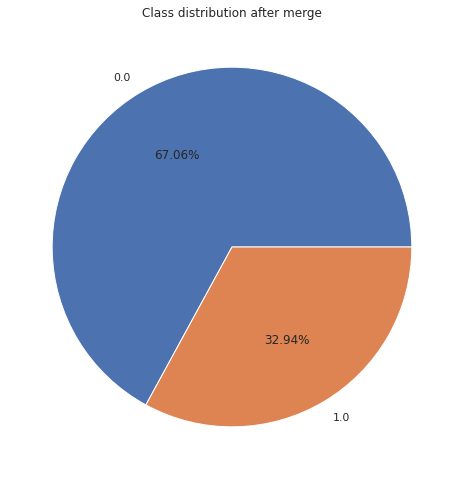

In [157]:
plt.pie(y_all_ds.value_counts(normalize=True), labels=set(y_train), autopct='%1.2f%%')
plt.title('Class distribution after merge')
plt.show()

In [158]:
X_num_ds = X_all_ds.select_dtypes(include=np.number)

In [159]:
scaler = StandardScaler()
X_std_all_ds = scaler.fit_transform(X_num_ds,
                                    X_num_ds.select_dtypes(include=np.number))


In [160]:
X_after_std_only_num = pd.DataFrame(data = X_std_all_ds,
             index= X_all_ds.index,
             columns= X_all_ds.select_dtypes(include=np.number).columns)

##Data correlation

<Axes: >

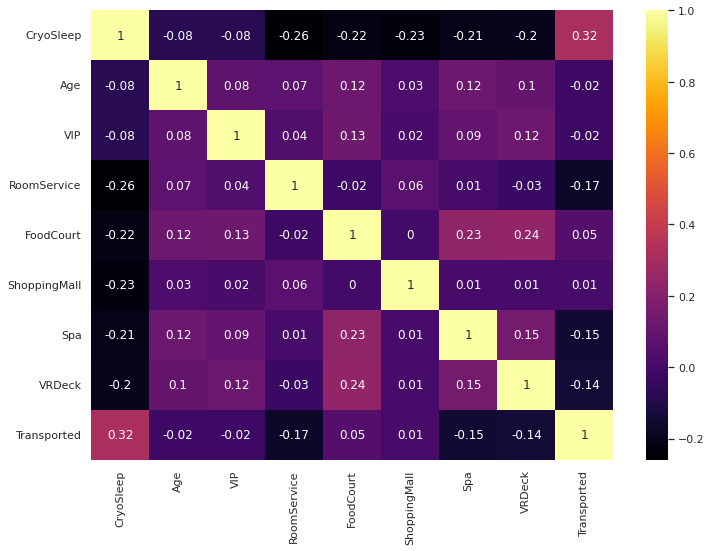

In [161]:
DF1_CORR = merged_all_DS.corr().round(2)
DF1_CORR
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(DF1_CORR, annot=True, cmap='inferno')

#Merged DS split to Train, Test, Validation DS

In [162]:
X_train_all_ds, X_test_all_ds, y_train_all_ds, y_test_all_ds = train_test_split(
    X_std_all_ds,y_all_ds,
    stratify=y_all_ds,
    test_size=0.1)

In [163]:
X_train_all_ds, X_val_all_ds, y_train_all_ds, y_val_all_ds = train_test_split(
    X_std_all_ds,
    y_all_ds,
    stratify=y_all_ds,
    test_size=0.1)

#Modeling

## Logistic regression

Logistic regression is simple model to implement and allows to check whether this case is easy to solve by very simple model. Logit model predict propability of an event occuring bsed on given DS on independent variable.

### C parametr estimation

In [164]:
C_values = [10.0**x for x in np.arange(-3, -1
                                       , 0.5)]
train_errs = list()
test_errs = list()

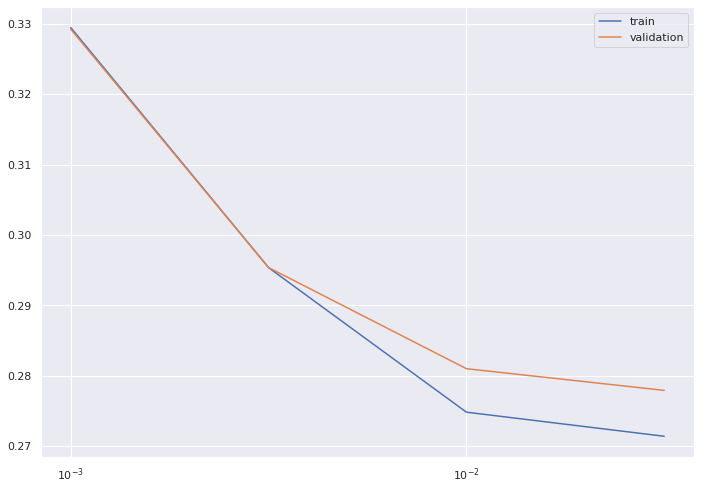

In [165]:
for C_value in C_values:
  lr = LogisticRegression(penalty="l1", C=C_value, solver='liblinear')
  lr.fit(X_train_all_ds, y_train_all_ds)

# Policzmy błąd:
#   score(X, y[, sample_weight])  Return the mean accuracy on the given test data and labels.
  train_errs.append(1.0 - lr.score(X_train_all_ds, y_train_all_ds))
  test_errs.append(1.0 - lr.score(X_test_all_ds, y_test_all_ds))

plt.semilogx(C_values, train_errs, C_values, test_errs)
plt.legend(("train", "validation"))
plt.show()

In [166]:
model_lr = LogisticRegression(random_state= 40, max_iter= 200, class_weight={0 : 0.33, 1: 0.67})

###Gridsearch for LR

In [167]:
grid_parem_searcher = {'penalty' : ['l1','l2'],
                       'C' : C_values,
                       'solver' : ['lbfgs', 'liblinear', 'saga'],
                       'max_iter' : [x*10 for x in range(1,5)]
                       }


In [168]:
searcher_lr = GridSearchCV(estimator=model_lr, param_grid=grid_parem_searcher, cv=5)
searcher_lr.fit(X_train_all_ds, y_train_all_ds)

GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight={0: 0.33, 1: 0.67},
                                          max_iter=200, random_state=40),
             param_grid={'C': [0.001, 0.0031622776601683794, 0.01,
                               0.03162277660168379],
                         'max_iter': [10, 20, 30, 40], 'penalty': ['l1', 'l2'],
                         'solver': ['lbfgs', 'liblinear', 'saga']})

In [169]:
grid_pred_train_lr = searcher_lr.predict(X_train_all_ds)
grid_pred_test_lr = searcher_lr.predict(X_test_all_ds)

###Result for LR model

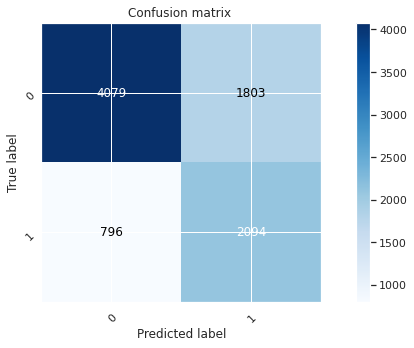

Results for TRAIN_after_gridsearch set with params
 {'C': 0.03162277660168379, 'max_iter': 10, 'penalty': 'l1', 'solver': 'saga'}
----
  Accuracy: 70.3716%
  Precision: 73.8084%
  Recall:    70.3716%
  F1 score:  71.1828%
  Mislabeled 2599 out of 8772




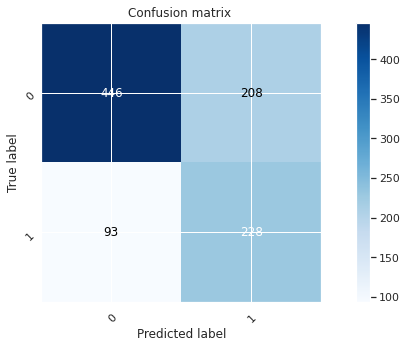

Results for TEST after_gridsearch set with params
 {'C': 0.03162277660168379, 'max_iter': 10, 'penalty': 'l1', 'solver': 'saga'}
----
  Accuracy: 69.1282%
  Precision: 72.7200%
  Recall:    69.1282%
  F1 score:  69.9852%
  Mislabeled 301 out of 975




In [170]:
cm_y_pred_train_lr = confusion_matrix(y_train_all_ds, grid_pred_train_lr)
plt.show(plot_confusion_matrix(cm_y_pred_train_lr, y_all_ds.unique()))

print_results(
    calculate_metrics(
        y_train_all_ds, grid_pred_train_lr,
         average='weighted'),
         classifier_id=f'TRAIN_after_gridsearch set with params\n {searcher_lr.best_params_}')

cm_y_pred_test_lr = confusion_matrix(y_test_all_ds, grid_pred_test_lr)
plt.show(plot_confusion_matrix(cm_y_pred_test_lr, y_all_ds.unique()))

print_results(
    calculate_metrics(
        y_test_all_ds, grid_pred_test_lr,
         average='weighted'),
         classifier_id=f'TEST after_gridsearch set with params\n {searcher_lr.best_params_}')

##XGBoost

XGBOOST model in shi structure has based on decission trees. To select correct 'correlations between variables it uses a gradient boost based on bagging bootstrap. XGB allows to transfer model to another programming language (julia, scala, java, R, Python) and allows to integration wiht clouds solution.

In [171]:
XBBoost_params = {'n_estimators':2,
                           'max_depth':2,
                           'learning_rate':0.8,
                           'objective' : 'binary:logistic'}

In [172]:
model_xgb = XGBClassifier(**XBBoost_params)
model_xgb.fit(X_train_all_ds,
               y_train_all_ds)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.8, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=2, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

### Result for XGB model

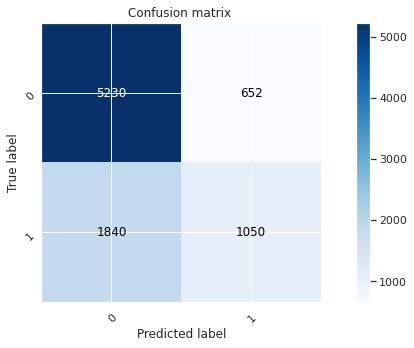

Results for TRAIN for XGB model set with params
 {'n_estimators': 2, 'max_depth': 2, 'learning_rate': 0.8, 'objective': 'binary:logistic'}
----
  Accuracy: 71.5914%
  Precision: 69.9280%
  Recall:    71.5914%
  F1 score:  69.2195%
  Mislabeled 2492 out of 8772




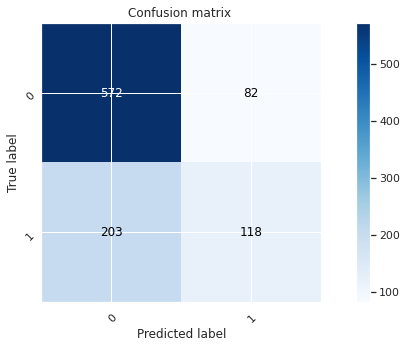

Results for TEST set with params
 {'n_estimators': 2, 'max_depth': 2, 'learning_rate': 0.8, 'objective': 'binary:logistic'}
----
  Accuracy: 70.7692%
  Precision: 68.9317%
  Recall:    70.7692%
  F1 score:  68.6124%
  Mislabeled 285 out of 975




In [173]:
preds_train_all_ds_xgb = model_xgb.predict(X_train_all_ds)
preds_test_all_ds_xgb = model_xgb.predict(X_test_all_ds)

cm_y_pred_train_XGB = confusion_matrix(y_train_all_ds, preds_train_all_ds_xgb)
plt.show(plot_confusion_matrix(cm_y_pred_train_XGB, y_all_ds.unique()))

print_results(
    calculate_metrics(
        y_train_all_ds, preds_train_all_ds_xgb,
         average='weighted'),
         classifier_id=f'TRAIN for XGB model set with params\n {XBBoost_params}')

cm_y_pred_test_XGB = confusion_matrix(y_test_all_ds, preds_test_all_ds_xgb)
plt.show(plot_confusion_matrix(cm_y_pred_test_XGB, y_all_ds.unique()))

print_results(
    calculate_metrics(
        y_test_all_ds, preds_test_all_ds_xgb,
         average='weighted'),
         classifier_id=f'TEST set with params\n {XBBoost_params}')

###Gridsearch for XGB

In [174]:
parameters_XGB_searcher = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

In [175]:
searcher_xgb = GridSearchCV(estimator= model_xgb, param_grid= parameters_XGB_searcher, cv=5)
searcher_xgb.fit(X_train_all_ds, y_train_all_ds)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.8, m...n=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=2,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=2, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': range(2, 10),
                         'n_estimators': range(60, 220, 40)})

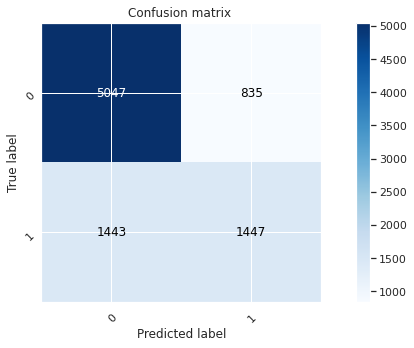

Results for TRAIN for XGB after gridsearch set with params
 {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100}
----
  Accuracy: 74.0310%
  Precision: 73.0359%
  Recall:    74.0310%
  F1 score:  73.1427%
  Mislabeled 2278 out of 8772




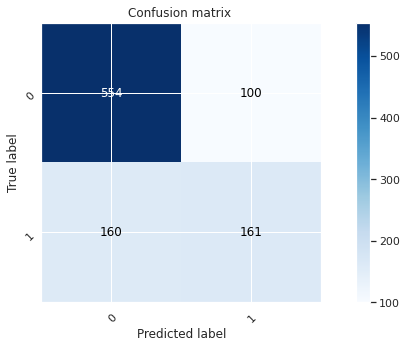

Results for TEST for XGB after gridsearch set with params
 {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100}
----
  Accuracy: 73.3333%
  Precision: 72.3546%
  Recall:    73.3333%
  F1 score:  72.5436%
  Mislabeled 260 out of 975




In [176]:
grid_pred_train_xgb = searcher_xgb.predict(X_train_all_ds)
grid_pred_test_xgb = searcher_xgb.predict(X_test_all_ds)

cm_y_pred_train_XGB_grid = confusion_matrix(y_train_all_ds, grid_pred_train_xgb)
plt.show(plot_confusion_matrix(cm_y_pred_train_XGB_grid, y_all_ds.unique()))
print_results(
    calculate_metrics(
        y_train_all_ds, grid_pred_train_xgb,
         average='weighted'),
         classifier_id=f'TRAIN for XGB after gridsearch set with params\n {searcher_xgb.best_params_}')

cm_y_pred_test_XGB_grid = confusion_matrix(y_test_all_ds, grid_pred_test_xgb)
plt.show(plot_confusion_matrix(cm_y_pred_test_XGB_grid, y_all_ds.unique()))
print_results(
    calculate_metrics(
        y_test_all_ds, grid_pred_test_xgb,
         average='weighted'),
         classifier_id=f'TEST for XGB after gridsearch set with params\n {searcher_xgb.best_params_}')

###Optuna for XGB

In [177]:
def objective_xgb(trial):
    """Define the objective function"""

    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'eval_metric': 'mlogloss',
        'use_label_encoder': False
    }

    # Fit the model
    optuna_model = XGBClassifier(**params)
    optuna_model.fit(X_train_all_ds, y_train_all_ds, verbose=False)

    # Make predictions
    y_pred_xgb_optuna = optuna_model.predict(X_test_all_ds)

    # Evaluate predictions
    accuracy = accuracy_score(y_test_all_ds, y_pred_xgb_optuna)
    return accuracy

optuna.logging.set_verbosity(optuna.logging.WARNING)
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb,
                n_trials=50)

print('Number of finished trials: {}'.format(len(study_xgb.trials)))
print('Best trial:')
trial_xgb = study_xgb.best_trial

print('  Value: {}'.format(trial_xgb.value))
print('  Params: ')

for key, value in trial_xgb.params.items():
    print('    {}: {}'.format(key, value))

params_optuna_xgb = trial_xgb.params
model_xgb_optuna = XGBClassifier(**params_optuna_xgb)
model_xgb_optuna.fit(X_train_all_ds, y_train_all_ds)
y_pred_test_xgb_optuna = model_xgb_optuna.predict(X_test_all_ds)

Number of finished trials: 50
Best trial:
  Value: 0.801025641025641
  Params: 
    max_depth: 8
    learning_rate: 0.9643249862330099
    n_estimators: 394
    min_child_weight: 1
    gamma: 2.6091551490939512e-05
    subsample: 0.6206978677308115
    colsample_bytree: 0.0352048148288183
    reg_alpha: 0.007717484021124691
    reg_lambda: 0.004590929935943986


####Restult for XGB after optuna

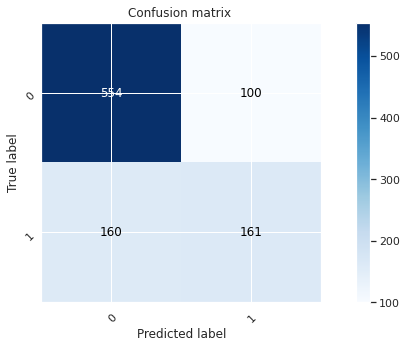

Results for TEST for XGB after gridsearch set with params
 {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100}
----
  Accuracy: 73.3333%
  Precision: 72.3546%
  Recall:    73.3333%
  F1 score:  72.5436%
  Mislabeled 260 out of 975




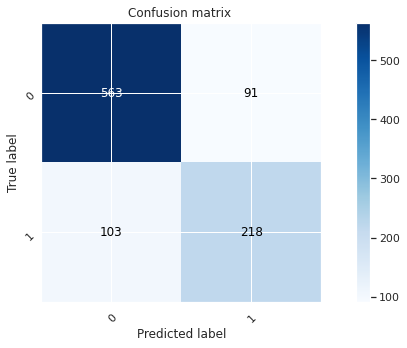

Results for TEST for XGB after optuna set with params
 {'max_depth': 8, 'learning_rate': 0.9643249862330099, 'n_estimators': 394, 'min_child_weight': 1, 'gamma': 2.6091551490939512e-05, 'subsample': 0.6206978677308115, 'colsample_bytree': 0.0352048148288183, 'reg_alpha': 0.007717484021124691, 'reg_lambda': 0.004590929935943986}
----
  Accuracy: 80.1026%
  Precision: 79.9304%
  Recall:    80.1026%
  F1 score:  80.0035%
  Mislabeled 194 out of 975




In [178]:
cm_y_pred_test_XGB_grid = confusion_matrix(y_test_all_ds, grid_pred_test_xgb)
plt.show(plot_confusion_matrix(cm_y_pred_test_XGB_grid, y_all_ds.unique()))
print_results(
    calculate_metrics(
        y_test_all_ds, grid_pred_test_xgb,
         average='weighted'),
         classifier_id=f'TEST for XGB after gridsearch set with params\n {searcher_xgb.best_params_}')

cm_y_pred_test_XGB_optuna = confusion_matrix(y_test_all_ds, y_pred_test_xgb_optuna)
plt.show(plot_confusion_matrix(cm_y_pred_test_XGB_optuna, y_all_ds.unique()))
print_results(
    calculate_metrics(
        y_test_all_ds, y_pred_test_xgb_optuna,
         average='weighted'),
         classifier_id=f'TEST for XGB after optuna set with params\n {params_optuna_xgb}')

## LightGBM

LGBM uses decission tree for predicting classes/values but LightGBM uses histogram-based algorithms which bucket continuous feature (attribute) values into discrete bins. This speeds up training and reduces memory usage. Advantages of histogram-based algorithms include the following:
Reduced cost of calculating the gain for each split
Use histogram subtraction for further speedup
Reduce memory usage
Reduce communication cost for distributed learning

In [179]:
param_grid_lgb = {
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [20, 40]
}

In [180]:
model_lgbm = lgb()

In [181]:
model_lgbm.fit(X_train_all_ds, y_train_all_ds)

LGBMClassifier()

###Result for LGB

In [182]:
y_pred_train_lgb = model_lgbm.predict(X_train_all_ds) 
y_pred_test_lgb = model_lgbm.predict(X_test_all_ds)

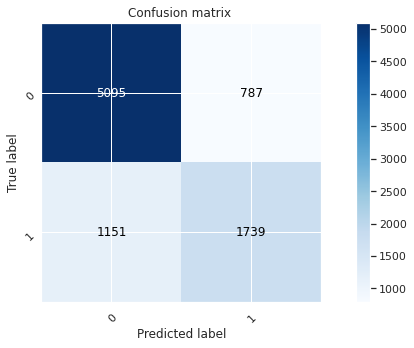

Results for TRAIN  for LGB set with params
 {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}
----
  Accuracy: 77.9070%
  Precision: 77.3788%
  Recall:    77.9070%
  F1 score:  77.4961%
  Mislabeled 1938 out of 8772




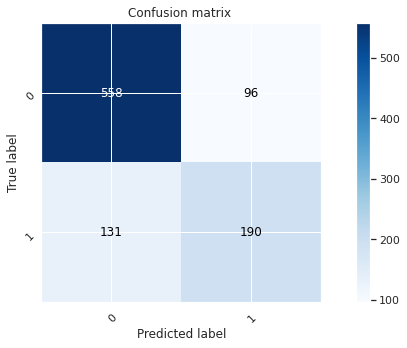

Results for TEST for LGB set with params
 {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}
----
  Accuracy: 76.7179%
  Precision: 76.1955%
  Recall:    76.7179%
  F1 score:  76.3501%
  Mislabeled 227 out of 975




In [183]:
cm_y_pred_train_lgb = confusion_matrix(y_train_all_ds, y_pred_train_lgb)
plt.show(plot_confusion_matrix(cm_y_pred_train_lgb, y_all_ds.unique()))
print_results(
    calculate_metrics(
        y_train_all_ds, y_pred_train_lgb,
         average='weighted'),
         classifier_id=f'TRAIN  for LGB set with params\n {model_lgbm.get_params()}')


cm_y_pred_test_lgb = confusion_matrix(y_test_all_ds, y_pred_test_lgb)
plt.show(plot_confusion_matrix(cm_y_pred_test_lgb, y_all_ds.unique()))
print_results(
    calculate_metrics(
        y_test_all_ds, y_pred_test_lgb,
         average='weighted'),
         classifier_id=f'TEST for LGB set with params\n {model_lgbm.get_params()}')

###Gridsearch for LGB

In [184]:
estimator_lgb = lgb(num_leaves=31)

In [185]:
searcher_lgb =  GridSearchCV(estimator= estimator_lgb, param_grid= param_grid_lgb, cv=5)
searcher_lgb.fit(X_train_all_ds,y_train_all_ds)

GridSearchCV(cv=5, estimator=LGBMClassifier(),
             param_grid={'learning_rate': [0.01, 0.1, 1],
                         'n_estimators': [20, 40]})

###Result for LGB after gridsearch

In [186]:
y_pred_train_lgb_grid = np.where(searcher_lgb.predict(X_train_all_ds)>0.5,1,0)
y_pred_test_lgb_grid = np.where(searcher_lgb.predict(X_test_all_ds)>0.5,1,0)

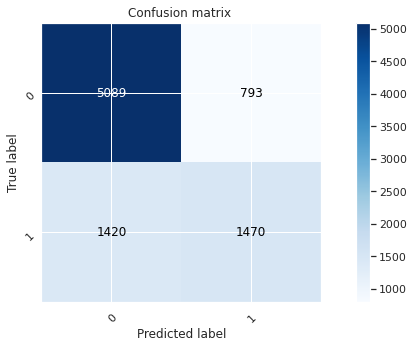

Results for TRAIN for LGB after gridsearch set with params
 {'learning_rate': 0.1, 'n_estimators': 20}
----
  Accuracy: 74.7720%
  Precision: 73.8266%
  Recall:    74.7720%
  F1 score:  73.8755%
  Mislabeled 2213 out of 8772




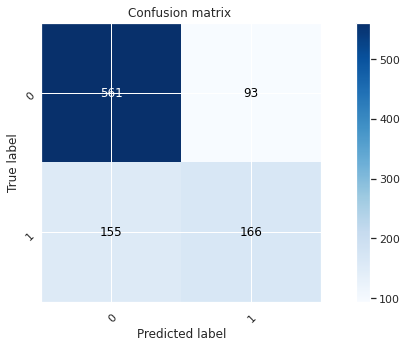

Results for TEST for LGB after gridsearch set with params
 {'learning_rate': 0.1, 'n_estimators': 20}
----
  Accuracy: 74.5641%
  Precision: 73.6574%
  Recall:    74.5641%
  F1 score:  73.7802%
  Mislabeled 248 out of 975




In [187]:
cm_y_pred_train_lgb_grid = confusion_matrix(y_train_all_ds, y_pred_train_lgb_grid)
plt.show(plot_confusion_matrix(cm_y_pred_train_lgb_grid, y_all_ds.unique()))
print_results(
    calculate_metrics(
        y_train_all_ds, y_pred_train_lgb_grid,
         average='weighted'),
         classifier_id=f'TRAIN for LGB after gridsearch set with params\n {searcher_lgb.best_params_}')

cm_y_pred_test_lgb_grid = confusion_matrix(y_test_all_ds, y_pred_test_lgb_grid)
plt.show(plot_confusion_matrix(cm_y_pred_test_lgb_grid, y_all_ds.unique()))
print_results(
    calculate_metrics(
        y_test_all_ds, y_pred_test_lgb_grid,
         average='weighted'),
         classifier_id=f'TEST for LGB after gridsearch set with params\n {searcher_lgb.best_params_}')

###Optuna for LGB

In [188]:
def objective_lgb(trial):
    
    param = {
        "objective": "binary",
        "boosting_type": "gbdt",
        "class_weight ": 'is_unbalance',
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "max_depth": trial.suggest_int("max_depth", 5, 100),
        "n_estimators": trial.suggest_int("n_estimators", 20, 150),
    }
    model = lgb(**param)  
    
    model.fit(X_train_all_ds,y_train_all_ds)
    
    preds = model.predict(X_test_all_ds)
    
    acc = accuracy_score(y_test_all_ds, preds)
    
    return acc

optuna.logging.set_verbosity(optuna.logging.WARNING)
study_lgb_optuna = optuna.create_study(study_name="lightgbm", direction="maximize")
study_lgb_optuna.optimize(objective_lgb, n_trials=100)
print('Best parameters:', study_lgb_optuna.best_params)
print('Best value:', study_lgb_optuna.best_value)
print('Best trial:', study_lgb_optuna.best_trial)

model_lgb_optuna = lgb(**study_lgb_optuna.best_params)
model_lgb_optuna.fit(X_train_all_ds, y_train_all_ds)
y_pred_test_lgb_optuna = model_lgb_optuna.predict(X_test_all_ds)

[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] lambda_l1 is set=8.410636066554162e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.410636066554162e-05
[LightGBM] [Warning] bagging_fraction is set=0.6161335215547801, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6161335215547801
[LightGBM] [Warning] lambda_l2 is set=4.779257021859462e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.779257021859462e-08
[LightGBM] [Warning] feature_fraction is set=0.747216839503164, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.747216839503164
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] lambda_l1 is set=3.6620058121585576e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6620058121585576e-08
[LightGBM] [Warning] bagging_fraction is set=0.48738213820546217, s

####Result for LGB after optuna

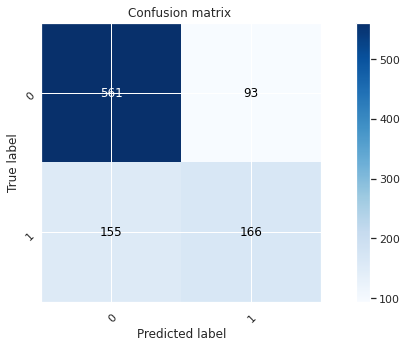

Results for TEST for LGB after gridsearch set with params
 {'learning_rate': 0.1, 'n_estimators': 20}
----
  Accuracy: 74.5641%
  Precision: 73.6574%
  Recall:    74.5641%
  F1 score:  73.7802%
  Mislabeled 248 out of 975




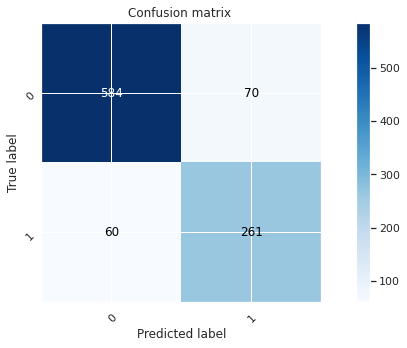

Results for TEST for LGB after optuna set with params
 {'lambda_l1': 3.879672600816683e-06, 'lambda_l2': 0.0006904009989984326, 'num_leaves': 220, 'feature_fraction': 0.8277680323578567, 'bagging_fraction': 0.7035045283202725, 'bagging_freq': 5, 'min_child_samples': 12, 'max_depth': 41, 'n_estimators': 147}
----
  Accuracy: 86.6667%
  Precision: 86.7880%
  Recall:    86.6667%
  F1 score:  86.7176%
  Mislabeled 130 out of 975




In [189]:
cm_y_pred_test_lgb_grid = confusion_matrix(y_test_all_ds, y_pred_test_lgb_grid)
plt.show(plot_confusion_matrix(cm_y_pred_test_lgb_grid, y_all_ds.unique()))
print_results(
    calculate_metrics(
        y_test_all_ds, y_pred_test_lgb_grid,
         average='weighted'),
         classifier_id=f'TEST for LGB after gridsearch set with params\n {searcher_lgb.best_params_}')

cm_y_pred_test_lgb_optuna= confusion_matrix(y_test_all_ds, y_pred_test_lgb_optuna)
plt.show(plot_confusion_matrix(cm_y_pred_test_lgb_optuna, y_all_ds.unique()))
print_results(
    calculate_metrics(
        y_test_all_ds, y_pred_test_lgb_optuna,
         average='weighted'),
         classifier_id=f'TEST for LGB after optuna set with params\n {study_lgb_optuna.best_params}')

## CatBoost

CatBoost is a machine learning method based on gradient boosting over decision trees.

Superior quality when compared with other GBDT libraries on many datasets.
Best in class prediction speed.
Support for both numerical and categorical features.
Fast GPU and multi-GPU support for training out of the box.
Visualization tools included.
Fast and reproducible distributed training with Apache Spark and CLI.

In [190]:
model_cbs = cbs(learning_rate=0.5, depth=6)
model_cbs.fit(X_train_all_ds, y_train_all_ds,verbose = False)

In [191]:
y_pred_train_cbs= model_cbs.predict(X_train_all_ds)
y_pred_test_cbs= model_cbs.predict(X_test_all_ds)

###Result for CBS

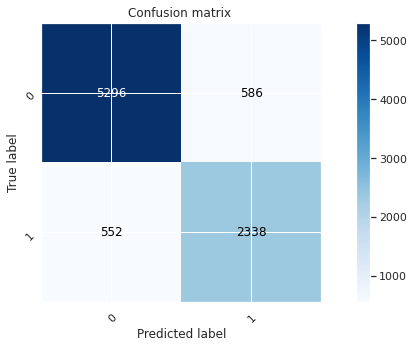

Results for TRAIN for CBS set with params
 learning_rate=0.5, depth=6
----
  Accuracy: 87.0269%
  Precision: 87.0680%
  Recall:    87.0269%
  F1 score:  87.0460%
  Mislabeled 1138 out of 8772




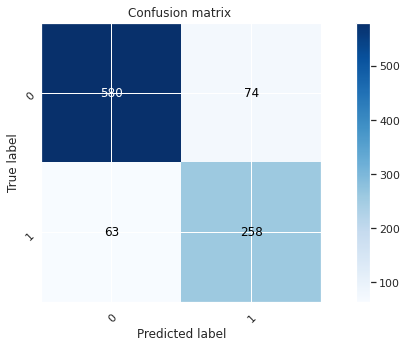

Results for TEST for CBS set with params
 learning_rate=0.5, depth=6
----
  Accuracy: 85.9487%
  Precision: 86.0896%
  Recall:    85.9487%
  F1 score:  86.0075%
  Mislabeled 137 out of 975




In [192]:
cm_y_pred_train_cbs = confusion_matrix(y_train_all_ds, y_pred_train_cbs)
plt.show(plot_confusion_matrix(cm_y_pred_train_cbs, y_all_ds.unique()))
print_results(
    calculate_metrics(
        y_train_all_ds, y_pred_train_cbs,
         average='weighted'),
         classifier_id=f'TRAIN for CBS set with params\n {"learning_rate=0.5, depth=6"}')

cm_y_pred_test_cbs = confusion_matrix(y_test_all_ds, y_pred_test_cbs)
plt.show(plot_confusion_matrix(cm_y_pred_test_cbs, y_all_ds.unique()))
print_results(
    calculate_metrics(
        y_test_all_ds, y_pred_test_cbs,
         average='weighted'),
         classifier_id=f'TEST for CBS set with params\n {"learning_rate=0.5, depth=6"}')

###Optuna for CBS

In [193]:
def objective_cbs(trial):
    model = cbs(
        iterations=trial.suggest_int("iterations", 100, 1000),
        learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        depth=trial.suggest_int("depth", 4, 10),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        random_strength=trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 10.0),
        od_type=trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        od_wait=trial.suggest_int("od_wait", 10, 50),
        verbose=False
    )
    model.fit(X_train_all_ds, y_train_all_ds)
    y_pred = model.predict(X_test_all_ds)
    acc = accuracy_score(y_test_all_ds, y_pred)
    return acc

warnings.filterwarnings('ignore')

study_cbs_optuna = optuna.create_study(study_name="catboost", direction="maximize")
study_cbs_optuna.optimize(objective_cbs, n_trials=33)

print("Number of finished trials: ", len(study_cbs_optuna.trials))
print("Best trial:")
trial_cbs = study_cbs_optuna.best_trial
print("  Value: ", trial_cbs.value)
print("  Params: ")
for key, value in trial_cbs.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  33
Best trial:
  Value:  0.8605128205128205
  Params: 
    iterations: 689
    learning_rate: 0.04325407559712424
    depth: 8
    l2_leaf_reg: 7.891973772128741e-05
    bootstrap_type: Bayesian
    random_strength: 1.012649554001234e-08
    bagging_temperature: 0.23653549880801683
    od_type: IncToDec
    od_wait: 30


In [194]:
model_cbs_optuna = cbs(**trial_cbs.params, verbose=False)
model_cbs_optuna.fit(X_train_all_ds, y_train_all_ds)
y_pred_test_cbs_optuna = model_cbs_optuna.predict(X_test_all_ds)

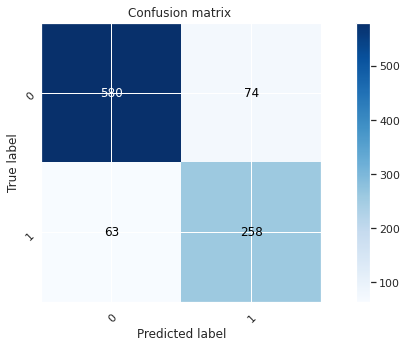

Results for TEST for CBS set with params
 learning_rate=0.5, depth=6
----
  Accuracy: 85.9487%
  Precision: 86.0896%
  Recall:    85.9487%
  F1 score:  86.0075%
  Mislabeled 137 out of 975




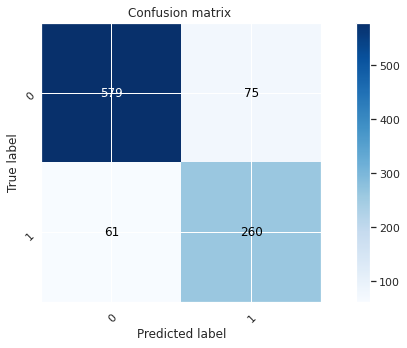

Results for TEST FOR CBS after optuna set with params
 {'iterations': 689, 'learning_rate': 0.04325407559712424, 'depth': 8, 'l2_leaf_reg': 7.891973772128741e-05, 'bootstrap_type': 'Bayesian', 'random_strength': 1.012649554001234e-08, 'bagging_temperature': 0.23653549880801683, 'od_type': 'IncToDec', 'od_wait': 30}
----
  Accuracy: 86.0513%
  Precision: 86.2359%
  Recall:    86.0513%
  F1 score:  86.1247%
  Mislabeled 136 out of 975




In [195]:
cm_y_pred_test_cbs = confusion_matrix(y_test_all_ds, y_pred_test_cbs)
plt.show(plot_confusion_matrix(cm_y_pred_test_cbs, y_all_ds.unique()))
print_results(
    calculate_metrics(
        y_test_all_ds, y_pred_test_cbs,
         average='weighted'),
         classifier_id=f'TEST for CBS set with params\n {"learning_rate=0.5, depth=6"}')

cm_y_pred_test_cbs_optuna = confusion_matrix(y_test_all_ds, y_pred_test_cbs_optuna)
plt.show(plot_confusion_matrix(cm_y_pred_test_cbs_optuna, y_all_ds.unique()))
print_results(
    calculate_metrics(
        y_test_all_ds, y_pred_test_cbs_optuna,
         average='weighted'),
         classifier_id=f'TEST FOR CBS after optuna set with params\n {trial_cbs.params}')

##Logistic regression with pytorch

In [196]:
X_train_all_ds.shape

(8772, 14)

In [197]:
epochs = 10_000
input_dim = 14
output_dim = 1
learning_rate = 0.01

In [198]:
model_pytorch_lr = LogisticRegression_pt(input_dim,output_dim)

In [199]:
criterion = torch.nn.BCELoss()

In [200]:
optimizer = torch.optim.SGD(model_pytorch_lr.parameters(),
                            lr=learning_rate)

In [201]:
X_train_all_ds.shape, X_test_all_ds.shape

((8772, 14), (975, 14))

In [202]:
y_train_all_ds.shape, y_test_all_ds.shape

((8772,), (975,))

In [203]:
X_train_tensor, X_test_tensor = torch.Tensor(X_train_all_ds),torch.Tensor(X_test_all_ds)
y_train_tensor, y_test_tensor = torch.Tensor(y_train_all_ds.values),torch.Tensor(y_test_all_ds.values)

###Cross valid in pytorch

In [208]:
losses = []
losses_test = []
Iterations = []
acc_train = []
acc_test = []
iter = 0
for epoch in tqdm(range(int(epochs)),desc='Training Epochs'):
    x = X_train_tensor
    labels = y_train_tensor
    optimizer.zero_grad()
    outputs = model_pytorch_lr(X_train_tensor)
    loss = criterion(torch.squeeze(outputs), labels) 
    
    loss.backward() # Computes the gradient of the given tensor w.r.t. the weights/bias
    
    optimizer.step() # Updates weights and biases with the optimizer (SGD)
    
    iter+=1
    if iter%1000==0:
        with torch.no_grad():
            # Calculating the loss and accuracy for the test dataset
            correct_test = 0
            total_test = 0
            outputs_test = torch.squeeze(model_pytorch_lr(X_test_tensor))
            loss_test = criterion(outputs_test, y_test_tensor)
            
            predicted_test = outputs_test.round().detach().numpy()
            total_test += y_test_tensor.size(0)
            correct_test += np.sum(predicted_test == y_test_tensor.detach().numpy())
            accuracy_test = 100 * correct_test/total_test
            acc_test.append(accuracy_test)
            losses_test.append(loss_test.item())
            
            # Calculating the loss and accuracy for the train dataset
            total = 0
            correct = 0
            total += y_train_tensor.size(0)
            correct += np.sum(torch.squeeze(outputs).round().detach().numpy() == y_train_tensor.detach().numpy())
            accuracy = 100 * correct/total
            acc_train.append(accuracy)
            losses.append(loss.item())
            Iterations.append(iter)
            
            print(f"Iteration: {iter}. \nTest - Loss: {loss_test.item()}. Accuracy: {accuracy_test}")
            print(f"Train -  Loss: {loss.item()}. Accuracy: {accuracy}\n")
            print(format(f'EPOCH NO {iter}','*^80'))

Training Epochs:  12%|█▏        | 1161/10000 [00:01<00:10, 868.11it/s]

Iteration: 1000. 
Test - Loss: 0.5266239047050476. Accuracy: 72.51282051282051
Train -  Loss: 0.5193359851837158. Accuracy: 73.02781577747378

*********************************EPOCH NO 1000**********************************


Training Epochs:  21%|██▏       | 2133/10000 [00:02<00:09, 860.42it/s]

Iteration: 2000. 
Test - Loss: 0.5263631343841553. Accuracy: 72.41025641025641
Train -  Loss: 0.5191747546195984. Accuracy: 73.01641586867305

*********************************EPOCH NO 2000**********************************


Training Epochs:  33%|███▎      | 3275/10000 [00:03<00:05, 1324.03it/s]

Iteration: 3000. 
Test - Loss: 0.5261450409889221. Accuracy: 72.41025641025641
Train -  Loss: 0.519047737121582. Accuracy: 73.02781577747378

*********************************EPOCH NO 3000**********************************


Training Epochs:  42%|████▏     | 4236/10000 [00:04<00:04, 1333.49it/s]

Iteration: 4000. 
Test - Loss: 0.5259610414505005. Accuracy: 72.41025641025641
Train -  Loss: 0.5189468860626221. Accuracy: 73.0734154126767

*********************************EPOCH NO 4000**********************************


Training Epochs:  52%|█████▎    | 5250/10000 [00:04<00:03, 1371.52it/s]

Iteration: 5000. 
Test - Loss: 0.5258046388626099. Accuracy: 72.3076923076923
Train -  Loss: 0.5188663005828857. Accuracy: 73.10761513907889

*********************************EPOCH NO 5000**********************************


Training Epochs:  62%|██████▏   | 6242/10000 [00:05<00:02, 1382.44it/s]

Iteration: 6000. 
Test - Loss: 0.5256709456443787. Accuracy: 72.3076923076923
Train -  Loss: 0.5188015103340149. Accuracy: 73.09621523027816

*********************************EPOCH NO 6000**********************************


Training Epochs:  72%|███████▏  | 7246/10000 [00:06<00:01, 1434.95it/s]

Iteration: 7000. 
Test - Loss: 0.5255559086799622. Accuracy: 72.3076923076923
Train -  Loss: 0.5187491774559021. Accuracy: 73.06201550387597

*********************************EPOCH NO 7000**********************************


Training Epochs:  83%|████████▎ | 8274/10000 [00:06<00:01, 1436.65it/s]

Iteration: 8000. 
Test - Loss: 0.5254563689231873. Accuracy: 72.3076923076923
Train -  Loss: 0.518706738948822. Accuracy: 73.05061559507524

*********************************EPOCH NO 8000**********************************


Training Epochs:  93%|█████████▎| 9275/10000 [00:07<00:00, 1382.83it/s]

Iteration: 9000. 
Test - Loss: 0.5253697037696838. Accuracy: 72.3076923076923
Train -  Loss: 0.5186722874641418. Accuracy: 73.03921568627452

*********************************EPOCH NO 9000**********************************


Training Epochs: 100%|██████████| 10000/10000 [00:08<00:00, 1217.43it/s]

Iteration: 10000. 
Test - Loss: 0.525294303894043. Accuracy: 72.41025641025641
Train -  Loss: 0.5186441540718079. Accuracy: 73.03921568627452

*********************************EPOCH NO 10000*********************************


###Result printing for LR in pytorch

In [207]:
acc_test

[72.51282051282051]

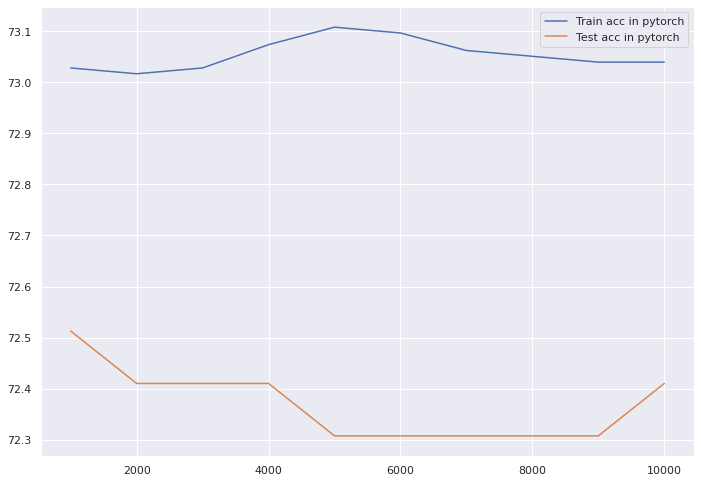

In [209]:
plt.plot(Iterations, acc_train, label ='Train acc in pytorch')
plt.plot(Iterations, acc_test, label ='Test acc in pytorch')
plt.legend()
plt.show()

# Validation the best model

In [210]:
y_val_cbs_optuna= model_cbs_optuna.predict(X_val_all_ds)

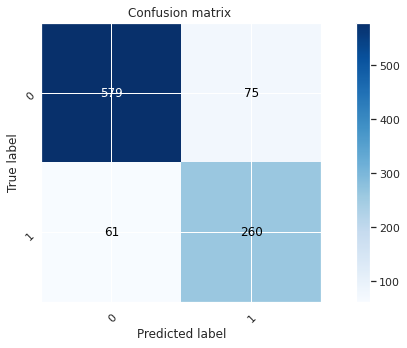

Results for TEST FOR CBS after optuna set with params
 {'iterations': 689, 'learning_rate': 0.04325407559712424, 'depth': 8, 'l2_leaf_reg': 7.891973772128741e-05, 'bootstrap_type': 'Bayesian', 'random_strength': 1.012649554001234e-08, 'bagging_temperature': 0.23653549880801683, 'od_type': 'IncToDec', 'od_wait': 30}
----
  Accuracy: 86.0513%
  Precision: 86.2359%
  Recall:    86.0513%
  F1 score:  86.1247%
  Mislabeled 136 out of 975




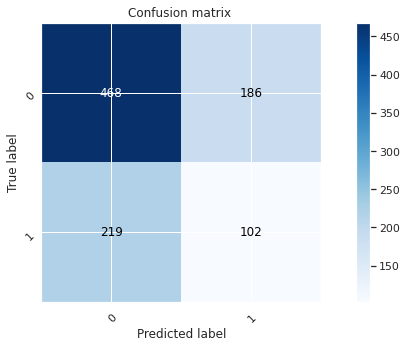

Results for VALIDATION FOR CBS after optuna set with params
 {'iterations': 689, 'learning_rate': 0.04325407559712424, 'depth': 8, 'l2_leaf_reg': 7.891973772128741e-05, 'bootstrap_type': 'Bayesian', 'random_strength': 1.012649554001234e-08, 'bagging_temperature': 0.23653549880801683, 'od_type': 'IncToDec', 'od_wait': 30}
----
  Accuracy: 58.4615%
  Precision: 57.3546%
  Recall:    58.4615%
  F1 score:  57.8472%
  Mislabeled 405 out of 975




In [211]:
cm_y_pred_test_cbs_optuna = confusion_matrix(y_test_all_ds, y_pred_test_cbs_optuna)
plt.show(plot_confusion_matrix(cm_y_pred_test_cbs_optuna, y_all_ds.unique()))
print_results(
    calculate_metrics(
        y_test_all_ds, y_pred_test_cbs_optuna,
         average='weighted'),
         classifier_id=f'TEST FOR CBS after optuna set with params\n {trial_cbs.params}')

cm_y_pred_val_cbs_optuna = confusion_matrix(y_test_all_ds, y_val_cbs_optuna)
plt.show(plot_confusion_matrix(cm_y_pred_val_cbs_optuna, y_all_ds.unique()))
print_results(
    calculate_metrics(
        y_test_all_ds, y_val_cbs_optuna,
         average='weighted'),
         classifier_id=f'VALIDATION FOR CBS after optuna set with params\n {trial_cbs.params}')